# Loading Dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib 
%matplotlib inline
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [2]:
import json
import pandas as pd
data_file_1 = open("/Users/houdeliao/Desktop/金工资料/FRE-GY 7773/Final Project/yelp_dataset/yelp_academic_dataset_business.json")
data_1 = []
for line in data_file_1:
    data_1.append(json.loads(line))
business = pd.DataFrame(data_1)
data_file_1.close()

# Text Preprocessing

## Data Cleaning：“yelp_Business”

In [3]:
## drop unuseful column 'hours','attributes'
business.drop(['hours','attributes'], axis=1, inplace=True)

## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## Standardize the state data
## Only keep the data in states list
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"Brewpubs, Breweries, Food"


In [4]:
usa.isnull().sum()

business_id       0
name              0
address           0
city              0
state             0
postal_code       0
latitude          0
longitude         0
stars             0
review_count      0
is_open           0
categories      102
dtype: int64

In [5]:
usa=usa.dropna(axis=0, subset=['categories'])

In [6]:
## select out all the restraunts & save in the new dataframe：us_restaurants
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]

## select out 16 cuisine types of restaurants & Set 'category' column rename the content in ‘category’
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants[:20]

/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_21535/1628943393.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  us_restaurants['category']=pd.Series()
/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_21535/1628943393.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_restaurants['category']=pd.Series()
/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,category
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",NaN
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",NaN
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"Pubs, Restaurants, Italian, Bars, American (Tr...",Greek
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",NaN
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,"Vietnamese, Food, Restaurants, Food Trucks",Vietnamese
12,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,"American (Traditional), Restaurants, Diners, B...",American
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"Food, Delis, Italian, Bakeries, Restaurants",Italian
15,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"Sushi Bars, Restaurants, Japanese",Japanese
19,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"Korean, Restaurants",Korean
22,kfNv-JZpuN6TVNSO6hHdkw,Hibachi Express,6625 E 82nd St,Indianapolis,IN,46250,39.904320,-86.053080,4.0,20,1,"Steakhouses, Asian Fusion, Restaurants",NaN


In [7]:
## drop null values in category, 
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])

## delete original column categories 
del us_restaurants['categories']

## and reset the index
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,1,Vietnamese
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.637133,-86.127217,2.5,28,1,American
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,Italian
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,Japanese
5,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,Korean
6,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.476117,-119.789339,2.5,339,1,Italian
7,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.159886,-86.773197,4.0,161,0,Japanese
8,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,Italian
9,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,American


In [8]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [9]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
category         object
dtype: object

In [10]:
## check missing values（缺失数据）
us_restaurants.isnull().sum()

business_id     0
name            0
address         0
city            0
state           0
postal_code     0
latitude        0
longitude       0
stars           0
review_count    0
is_open         0
category        0
dtype: int64

##  Data Cleaning：“yelp_Review”

In [11]:
## load review table
# review = pd.read_csv('yelp_review.csv')
# review.head()
import json
import pandas as pd
data_file_2 = open("/Users/houdeliao/Desktop/金工资料/FRE-GY 7773/Final Project/yelp_dataset/yelp_academic_dataset_review.json")
data_2 = []
for line in data_file_2:
    data_2.append(json.loads(line))
review = pd.DataFrame(data_2)
data_file_2.close()

In [12]:
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [13]:
## check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64

In [14]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

## Merge two datasets to get——> “restaurants_reviews”

In [15]:
## Merge two datasets on 'business_id' to get “restaurants_reviews”
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

In [16]:
restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars_x,review_count,is_open,category,review_id,user_id,stars_y,useful,funny,cool,text,date
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,9fmAJ76g2-CKbbU14Ai1aw,LNprC9Mi8Xqtgk1KCFlKAg,4.0,0,0,0,"I like Tsevis because they have good gyros, wh...",2014-02-25 22:34:59
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,OCmjANuYad62GAyY0NI8bQ,z-i_Qv-E3qeHfdPZddpwYQ,4.0,0,0,0,Good Greek American food. I highly recomend th...,2013-01-29 04:27:04
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,QPZ66Xk54CprqZgTW1QTdQ,m6YhwUNoehMm6s52w9A4eA,2.0,0,0,0,Wife and I have eaten lunch here a few times o...,2013-10-25 15:39:01
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,yUpKEiSWjcix-zWHFMT39w,-YAnRx8VSDkASxlylv3dyg,1.0,0,0,0,After about 7 minutes of waiting patiently for...,2014-07-16 19:17:34
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,Greek,JR0MWE4psJqD2MyHbMckxA,WJ-veSDe63t0HnCu2E1NSA,1.0,3,0,0,Three of us decided to try this place out last...,2012-12-17 18:37:23


In [17]:
## Rename columns 
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## Replace all special symbols and line breaks in comments with spaces & count each review‘s number of words and save the number in 'num_words_review'
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

# label reviews as positive or negative based on 'review_star'
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_21535/3773725611.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))


## Exploratory Data Analysis

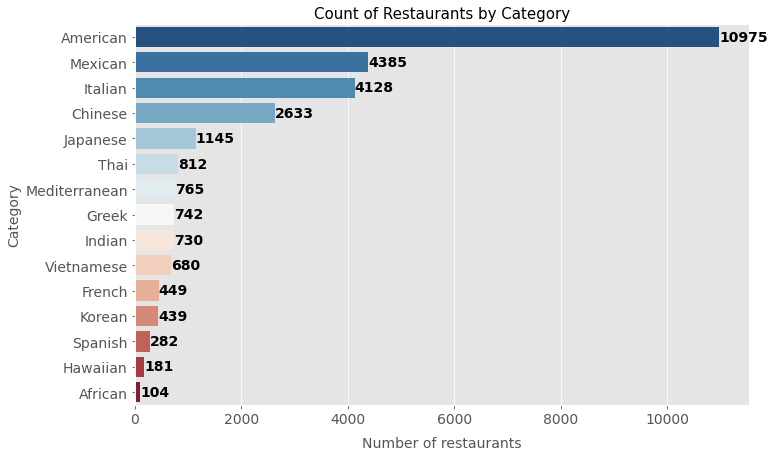

In [18]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


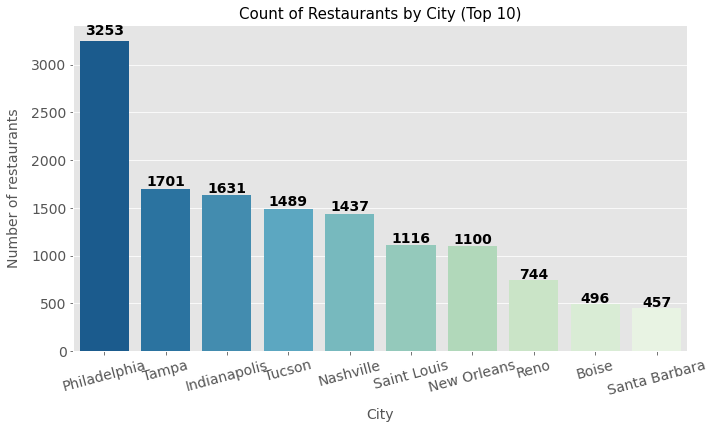

In [19]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    

In [42]:
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.9553,-82.4563,4.0000,10,1,Vietnamese
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.6371,-86.1272,2.5000,28,1,American
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.9161,-82.7605,4.5000,100,0,Italian
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.9539,-75.1432,4.0000,245,1,Japanese
5,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.9432,-75.1626,4.5000,205,1,Korean
6,9OG5YkX1g2GReZM0AskizA,Romano's Macaroni Grill,5505 S Virginia St,Reno,NV,89502,39.4761,-119.7893,2.5000,339,1,Italian
7,tMkwHmWFUEXrC9ZduonpTg,The Green Pheasant,215 1st Ave S,Nashville,TN,37201,36.1599,-86.7732,4.0000,161,0,Japanese
8,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.9398,-75.1574,4.0000,65,0,Italian
9,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.9626,-75.1357,3.5000,65,1,American


In [43]:
df_cat = us_restaurants[['state','category']]
df_cat_dum = pd.get_dummies(data = df_cat, columns = df_cat.columns)
df = pd.concat((us_restaurants, df_cat_dum ), axis = 1)
df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category,state_AZ,state_CA,state_DE,state_FL,state_ID,state_IL,state_IN,state_LA,state_MO,state_MT,state_NC,state_NJ,state_NV,state_PA,state_TN,category_African,category_American,category_Chinese,category_French,category_Greek,category_Hawaiian,category_Indian,category_Italian,category_Japanese,category_Korean,category_Mediterranean,category_Mexican,category_Spanish,category_Thai,category_Vietnamese
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.9553,-82.4563,4.0000,10,1,Vietnamese,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,il_Ro8jwPlHresjw9EGmBg,Denny's,8901 US 31 S,Indianapolis,IN,46227,39.6371,-86.1272,2.5000,28,1,American,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.9161,-82.7605,4.5000,100,0,Italian,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.9539,-75.1432,4.0000,245,1,Japanese,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28445,gPr1io7ks0Eo3FDsnDTYfg,Tata Cafe,7201 Germantown Ave,Philadelphia,PA,19119,40.0604,-75.1911,4.0000,21,0,Italian,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28446,wVxXRFf10zTTAs11nr4xeA,PrimoHoagies,6024 Ridge Ave,Philadelphia,PA,19128,40.0325,-75.2144,3.0000,55,1,Italian,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28447,sf_oQ62L8UEnOOLf00nNGA,Pizza Hut,5028 Old Hickory,Hermitage,TN,37076,36.1932,-86.6147,3.0000,6,1,Italian,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
28448,8n93L-ilMAsvwUatarykSg,Kitchen Gia,3716 Spruce St,Philadelphia,PA,19104,39.9510,-75.1982,3.0000,22,0,American,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


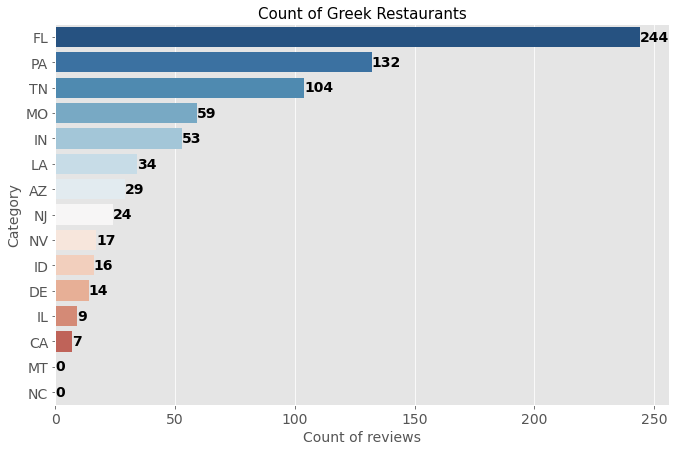

In [44]:
plt.figure(figsize=(11,7))
grouped = df.groupby('state')['category_Greek'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Greek Restaurants', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

## Review Analysis

In [20]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)


## convert text to lower case 
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

restaurants_reviews.head()


/var/folders/25/1tfgc5812rq0_t5gjmwl1f140000gn/T/ipykernel_21535/2960596005.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n','').str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')


,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,useful,funny,cool,text,date,num_words_review,labels,removed_punct_text
0,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,9fmAJ76g2-CKbbU14Ai1aw,LNprC9Mi8Xqtgk1KCFlKAg,4.0000,0,0,0,"i like tsevis because they have good gyros, wh...",2014-02-25 22:34:59,53,positive,i like tsevis because they have good gyros whi...
1,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,OCmjANuYad62GAyY0NI8bQ,z-i_Qv-E3qeHfdPZddpwYQ,4.0000,0,0,0,good greek american food. i highly recomend th...,2013-01-29 04:27:04,26,positive,good greek american food i highly recomend the...
2,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,QPZ66Xk54CprqZgTW1QTdQ,m6YhwUNoehMm6s52w9A4eA,2.0000,0,0,0,wife and i have eaten lunch here a few times o...,2013-10-25 15:39:01,184,negative,wife and i have eaten lunch here a few times o...
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,yUpKEiSWjcix-zWHFMT39w,-YAnRx8VSDkASxlylv3dyg,1.0000,0,0,0,after about 7 minutes of waiting patiently for...,2014-07-16 19:17:34,186,negative,after about 7 minutes of waiting patiently for...
4,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.5652,-90.3211,3.0000,19,0,Greek,JR0MWE4psJqD2MyHbMckxA,WJ-veSDe63t0HnCu2E1NSA,1.0000,3,0,0,three of us decided to try this place out last...,2012-12-17 18:37:23,224,negative,three of us decided to try this place out last...


In [21]:
import sys
positive_words=[]
with open('/Users/houdeliao/Desktop/positive.txt','r') as p:
    for pline in p:
        positive_words.append(pline.strip('\n'))

## load negative_.txt file into ‘negative_words’ list
file_negative = open('/Users/houdeliao/Desktop/negative_.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]


In [22]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df


In [23]:
## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words


In [24]:
## Get the score for importance
def get_polarity_score(dataset):
    dataset.text = dataset.text.apply(filter_words)
    
    terms_train=list(dataset['text'])
    class_train=list(dataset['labels'])
    
    ## get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts=vectorizer.fit_transform(terms_train)
    
    ## run model
    svm = LinearSVC()
    svm.fit(feature_train_counts, class_train)
    
    ## create dataframe for score of each word in a review calculated by svm model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names()})
    
    ## get frequency of each word in all reviews in specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] =='positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score.score = cuisine_polarity_score.score.astype(float)
    cuisine_polarity_score.frequency = cuisine_polarity_score.frequency.astype(int)
    
    ## calculate polarity score 
    cuisine_polarity_score['polarity'] = cuisine_polarity_score.score * cuisine_polarity_score.frequency / cuisine_reviews.shape[0]
    
    cuisine_polarity_score.polarity = cuisine_polarity_score.polarity.astype(float)
    ## drop unnecessary words
    unuseful_positive_words = ['great','amazing','love','best','awesome','excellent','good',
                                                   'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous','liked','incredible','outstanding','positive']
    unuseful_negative_words =  ['bad','disappointed','disappointing','horrible','disappoint','lacking','unfortunately','sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score


In [25]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)
    

In [26]:
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df


In [27]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

## For Example Japanese Cuisine

In [28]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.9)
print('Total %d number of reviews' % Japanese_train.shape[0])

Total 13683 number of reviews


In [29]:
Japanese_polarity_score = get_polarity_score(Japanese_train)
get_top_words(Japanese_polarity_score, 'positive',20)

/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/houdeliao/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,score,frequency,polarity
word,,,
delicious,0.6048,2664,0.1177
fresh,0.1935,2818,0.0398
recommend,0.2102,1483,0.0228
reasonable,0.6947,401,0.0204
beautiful,0.8797,271,0.0174
friendly,0.1192,1674,0.0146
variety,0.3402,415,0.0103
helpful,0.4710,299,0.0103
fun,0.2937,472,0.0101


In [30]:
get_top_words(Japanese_polarity_score,'negative',20)

,score,frequency,polarity
word,,,
work,-0.2228,333,-0.0054
cold,-0.3131,215,-0.0049
slow,-0.3276,201,-0.0048
expensive,-0.2906,217,-0.0046
hard,-0.1735,313,-0.0040
bland,-0.9552,54,-0.0038
warm,-0.2208,204,-0.0033
wrong,-0.2105,211,-0.0032
mediocre,-1.0040,42,-0.0031
